# Analyse the Visual Attention Data

In [100]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
import scipy.ndimage
from pygments.lexers import PythonLexer
from tqdm.notebook import tqdm
import matplotlib.patches as patches
import PIL
import PIL.Image
import numpy as np
from mpl_chord_diagram import chord_diagram
plt.rcParams['savefig.facecolor']='white'

In [101]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData
0,212,iterative,apply,66794,False,268-191 151-70 151-70 146-89 135-12 135-65 120...,10105 34435 35005 39192 47146 56587 61358 66794
1,245,iterative,apply,21078,True,156-17 174-195 129-44 131-62 141-93 141-114 14...,1123 3472 14145 14878 16035 19911 21078
2,272,iterative,apply,81561,True,188-192 104-34 132-69 149-89,16519 78023 79043 81561
3,296,iterative,apply,22825,False,160-195 122-115 148-9 138-34 140-60 132-94 153...,4194 11386 13568 14369 15567 17215 21808 22825
4,302,iterative,apply,20310,True,69-204 84-191 150-197 254-200 183-14 85-36 95-...,4193 5008 5850 6351 8856 10441 11790 13309 20310
...,...,...,...,...,...,...,...
297,213,list-comprehension,LinkedList,153552,False,42-22 65-45 51-123 81-143 111-161 100-143 50-1...,4155 9379 12561 13652 21857 23971 25078 25989 ...
298,252,list-comprehension,LinkedList,47933,True,110-12 118-37 101-117 126-142 134-170 137-190 ...,3853 4218 8660 9020 9434 9893 11026 11335 1200...
300,297,list-comprehension,LinkedList,48782,True,80-9 90-33 88-125 103-146 109-170 114-194 103-...,3545 4213 6711 7143 7700 8598 9962 10333 11843...
301,309,list-comprehension,LinkedList,55439,False,78-15 80-37 81-117 109-146 106-170 106-192 114...,3924 4856 5841 6974 7497 8040 10490 11359 1325...


In [102]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list

In [103]:
def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [104]:
df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

In [105]:
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData,NumberOfClicks,AverageTimeOfClicks
0,212,iterative,apply,66794,False,"[(268, 191), (151, 70), (151, 70), (146, 89), ...","[10.105, 34.435, 35.005, 39.192, 47.146, 56.58...",8,8.349250
1,245,iterative,apply,21078,True,"[(156, 17), (174, 195), (129, 44), (131, 62), ...","[1.123, 3.472, 14.145, 14.878, 16.035, 19.911,...",7,3.011143
2,272,iterative,apply,81561,True,"[(188, 192), (104, 34), (132, 69), (149, 89)]","[16.519, 78.023, 79.043, 81.561]",4,20.390250
3,296,iterative,apply,22825,False,"[(160, 195), (122, 115), (148, 9), (138, 34), ...","[4.194, 11.386, 13.568, 14.369, 15.567, 17.215...",8,2.853125
4,302,iterative,apply,20310,True,"[(69, 204), (84, 191), (150, 197), (254, 200),...","[4.193, 5.008, 5.85, 6.351, 8.856, 10.441, 11....",9,2.256667
...,...,...,...,...,...,...,...,...,...
297,213,list-comprehension,LinkedList,153552,False,"[(42, 22), (65, 45), (51, 123), (81, 143), (11...","[4.155, 9.379, 12.561, 13.652, 21.857, 23.971,...",51,3.010824
298,252,list-comprehension,LinkedList,47933,True,"[(110, 12), (118, 37), (101, 117), (126, 142),...","[3.853, 4.218, 8.66, 9.02, 9.434, 9.893, 11.02...",39,1.229051
300,297,list-comprehension,LinkedList,48782,True,"[(80, 9), (90, 33), (88, 125), (103, 146), (10...","[3.545, 4.213, 6.711, 7.143, 7.7, 8.598, 9.962...",37,1.318432
301,309,list-comprehension,LinkedList,55439,False,"[(78, 15), (80, 37), (81, 117), (109, 146), (1...","[3.924, 4.856, 5.841, 6.974, 7.497, 8.04, 10.4...",36,1.539972


## Descriptive: Get Number of Clicks per Algorithm

In [106]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_tmp = df_visual[["Algorithm", "ProgrammingStyle", "NumberOfClicks"]].groupby(["Algorithm", "ProgrammingStyle"]).describe()
df_tmp.to_csv("./results/visual_attention_number_of_clicks_per_algorithm.csv")
df_tmp

NumberOfClicks                              \
                                          count       mean        std   min   
Algorithm     ProgrammingStyle                                                
LinkedList    higher-order                  5.0  39.800000  21.288495  11.0   
              iterative                     6.0  45.333333  12.785408  33.0   
              list-comprehension            7.0  41.714286  15.923926  25.0   
              recursive                     6.0  31.166667  16.129683   8.0   
apply         higher-order                  8.0   3.500000   0.755929   3.0   
              iterative                     7.0   7.142857   1.676163   4.0   
              list-comprehension            6.0   3.666667   1.211060   3.0   
              recursive                     7.0  20.571429  14.953897   6.0   
computer      higher-order                  7.0  44.142857  35.690468  18.0   
              iterative                     5.0  29.400000   4.774935  25.0   
              list-comprehension            8.0  33.125000  16.348329  19.0   
              recursive                     4.0  26.500000  16.583124   5.0   
condition_sum higher-order                  6.0   5.833333   3.188521   3.0   
              iterative                     7.0  16.857143  10.447146   8.0   
              list-comprehension            7.0   9.428571   3.457222   6.0   
              recursive                     6.0  12.500000   8.093207   6.0   
find          higher-order                  5.0  20.800000  26.499057   7.0   
              iterative                     7.0   9.714286   4.535574   6.0   
              list-comprehension            6.0   5.333333   2.422120   3.0   
              recursive                     6.0  21.500000   7.918333  12.0   
is_prime      higher-order                  7.0  13.285714  13.250337   4.0   
              iterative                     9.0  15.777778  10.732867   8.0   
              list-comprehension            5.0   2.800000   0.836660   2.0   
              recursive                     7.0  12.857143   4.220133   8.0   
max           higher-order                  8.0   7.000000   5.477226   3.0   
              iterative                     6.0  13.000000   6.782330   5.0   
              list-comprehension            7.0   8.428571   4.197505   6.0   
              recursive                     7.0  21.285714  18.364044   7.0   
node          higher-order                  7.0  34.571429  15.778225  10.0   
              iterative                     7.0  40.428571  12.594405  28.0   
              list-comprehension            5.0  36.000000  19.685020  17.0   
              recursive                     5.0  46.000000  17.818530  30.0   
prime_factors higher-order                  7.0  17.857143   8.513295   9.0   
              iterative                     6.0  23.833333   7.704977  17.0   
              list-comprehension            6.0  22.000000  32.631273   4.0   
              recursive                     6.0  51.166667  48.329770  18.0   
quad_mul      higher-order                  5.0   7.000000   1.224745   6.0   
              iterative                     8.0  13.750000   5.922114   9.0   
              list-comprehension            6.0  12.666667  11.075498   6.0   
              recursive                     6.0   5.000000   1.673320   2.0   
store         higher-order                  4.0  51.250000  23.271943  17.0   
              iterative                     6.0  56.833333  23.327380  12.0   
              list-comprehension            6.0  75.333333  36.843814  32.0   
              recursive                     6.0  63.666667  17.750117  33.0   
total         higher-order                 69.0  20.739130  22.513821   3.0   
              iterative                    74.0  23.675676  18.224707   4.0   
              list-comprehension           69.0  23.043478  26.571455   2.0   
              recursive                    66.0  27.712121  24.958282   2.0   

   

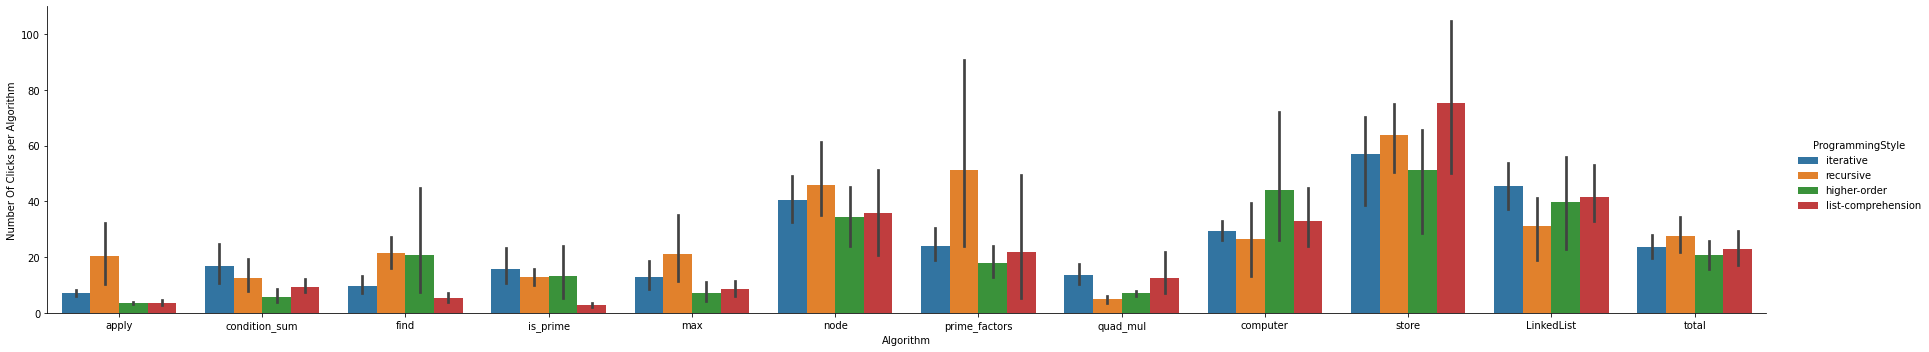

In [107]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="NumberOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5,
                 aspect=5)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per Algorithm')
plt.savefig("./results/visual_attention_number_of_clicks_per_algorithm.png")
plt.show()
plt.close('all')

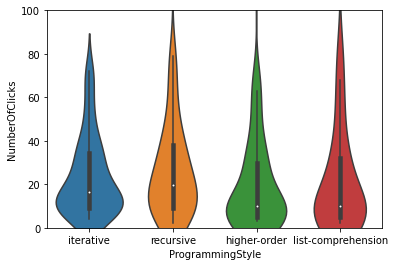

In [108]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0))
plt.savefig("./results/visual_attention_number_of_clicks_per_style_violin.png")
plt.show()
plt.close('all')

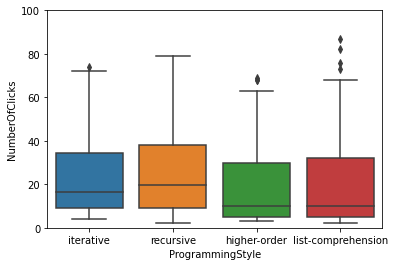

In [109]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.boxplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0))
plt.savefig("./results/visual_attention_number_of_clicks_per_style_boxplot.png")
plt.show()
plt.close('all')

## Descriptive: Get Average Time of Clicks per Algorithm

In [110]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_tmp = df_visual[["Algorithm", "ProgrammingStyle", "AverageTimeOfClicks"]].groupby(["Algorithm", "ProgrammingStyle"]).describe()
df_tmp.to_csv("./results/visual_attention_average_time_of_clicks_per_algorithm.csv")
df_tmp

AverageTimeOfClicks                        \
                                               count       mean        std   
Algorithm     ProgrammingStyle                                               
LinkedList    higher-order                       5.0   3.870583   4.786513   
              iterative                          6.0   1.322143   0.315762   
              list-comprehension                 7.0   1.666785   0.665028   
              recursive                          6.0   2.871412   3.427894   
apply         higher-order                       8.0   3.044512   2.517295   
              iterative                          7.0   5.693800   6.896022   
              list-comprehension                 6.0  15.986319  26.145068   
              recursive                          7.0   2.278829   1.593352   
computer      higher-order                       7.0   2.481384   1.274106   
              iterative                          5.0   2.561939   1.110463   
              list-comprehension                 8.0   1.847289   0.584720   
              recursive                          4.0   6.992149   9.903901   
condition_sum higher-order                       6.0  19.009406  27.818300   
              iterative                          7.0   2.245018   0.716550   
              list-comprehension                 7.0   4.055946   1.762658   
              recursive                          6.0   2.582092   0.875142   
find          higher-order                       5.0   8.156059   7.688899   
              iterative                          7.0   2.245674   1.269006   
              list-comprehension                 6.0   4.746681   2.964698   
              recursive                          6.0   2.460136   2.023651   
is_prime      higher-order                       7.0   5.863747   6.851100   
              iterative                          9.0   2.895691   2.410473   
              list-comprehension                 5.0   2.037000   0.938687   
              recursive                          7.0   3.097253   2.870054   
max           higher-order                       8.0   3.377257   2.118235   
              iterative                          6.0   2.977039   2.396996   
              list-comprehension                 7.0   2.854884   1.355707   
              recursive                          7.0   3.875878   4.335688   
node          higher-order                       7.0   1.714489   0.472124   
              iterative                          7.0   1.694089   0.846538   
              list-comprehension                 5.0   2.575038   1.994722   
              recursive                          5.0   2.018593   0.974096   
prime_factors higher-order                       7.0   5.027794   3.789875   
              iterative                          6.0   3.045216   3.042379   
              list-comprehension                 6.0  11.336141  20.253148   
              recursive                          6.0   2.865086   0.921142   
quad_mul      higher-order                       5.0   5.589538   6.248374   
              iterative                          8.0   3.340192   2.945449   
              list-comprehension                 6.0   4.506165   3.229365   
              recursive                          6.0   4.022583   3.245806   
store         higher-order                       4.0   2.185366   1.759323   
              iterative                          6.0   3.878688   6.081055   
              list-comprehension                 6.0   1.476232   0.516884   
              recursive                          6.0   1.391671   0.135009   
total         higher-order                      69.0   5.331375   9.590110   
              iterative                         74.0   2.920014   3.244970   
              list-comprehension                69.0   4.727406  10.091997   
              recursive                         66.0   3.030048   3.323463   

                                                      

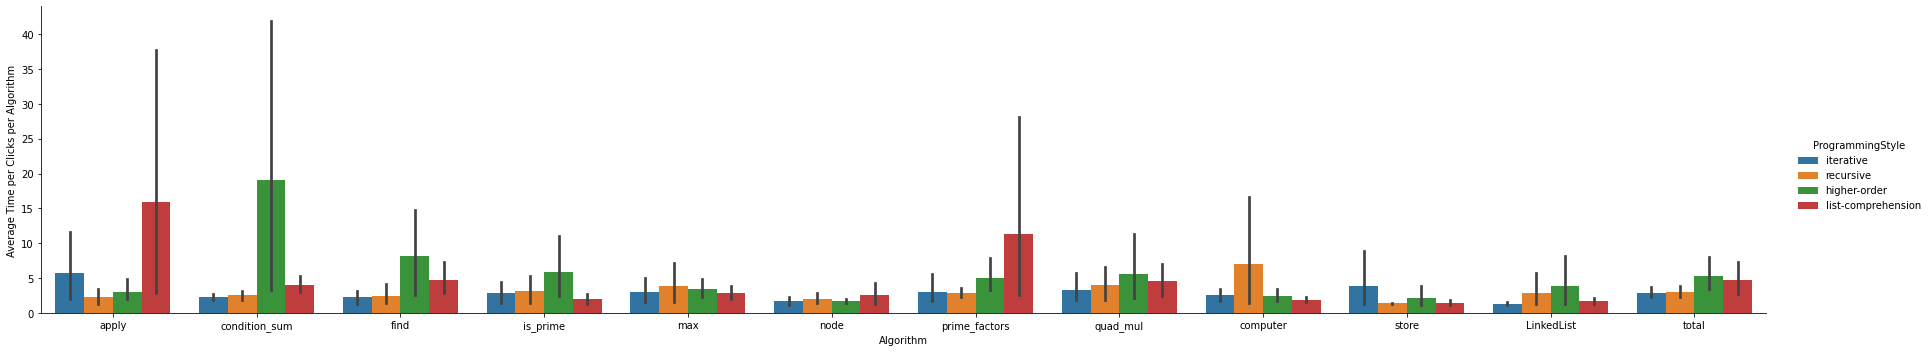

In [111]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="AverageTimeOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5, aspect=5)
ax.tight_layout()
ax.set(ylabel='Average Time per Clicks per Algorithm')
plt.savefig("./results/visual_attention_average_time_of_clicks_per_algorithm.png")
plt.show()
plt.close('all')

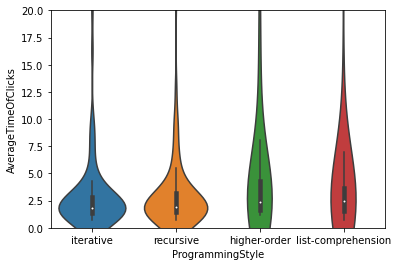

In [112]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0))
plt.savefig("./results/visual_attention_average_time_of_clicks_per_style_violin.png")
plt.show()
plt.close('all')

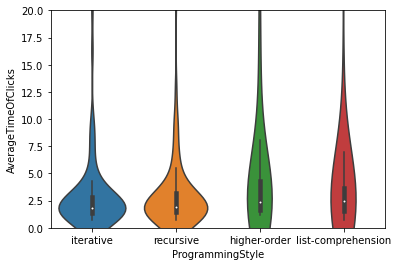

In [113]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0))
plt.savefig("./results/visual_attention_average_time_of_clicks_per_style_boxplot.png")
plt.show()
plt.close('all')

# Descriptive: Areas Of Interest

In [114]:
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

In [115]:
color_palette = sns.color_palette("hls", 16)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "RecursiveBaseCase" : color_palette[10],
    "HigherOrder" : color_palette[11],
    "ListComprehension" : color_palette[12],
    "InputPreparation" : color_palette[13],
    "StartOfAlgorithm" : color_palette[14],
    "Class" : color_palette[15],
}
aoi_colors = color_palette
aoi_numbers = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping.items())}
aoi_names = [name for name, _value in color_palette_mapping.items()]

In [116]:
def aoi_idx_to_convoluted_idx(aoi_idx):
    if aoi_idx < 5:
        return aoi_idx
    if 6 <= aoi_idx <= 12:
        return 6
    if 13 <= aoi_idx:
        return aoi_idx-6

def aoi_name_to_convoluted_name(aoi_name):
    if aoi_name in ["Iteration", "IterationHead", "IterationBody", "RecursiveCall", "RecursiveBaseCase", "HigherOrder", "ListComprehension"]:
        return "StyleSpecific"
    return aoi_name

color_palette = sns.color_palette("hls", 10)
color_palette_mapping_convoluted = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "StyleSpecific" : color_palette[6],
    "InputPreparation" : color_palette[7],
    "StartOfAlgorithm" : color_palette[8],
    "Class" : color_palette[9],
}
aoi_colors_convoluted = color_palette
aoi_numbers_convoluted = {name : idx for idx, (name, _value) in enumerate(color_palette_mapping_convoluted.items())}
aoi_names_convoluted = [name for name, _value in color_palette_mapping_convoluted.items()]

#### Create bounding boxes for AOIS

In [117]:
#load file
df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
image_path = "./results/aois/"
font_path="\\data\\fonts\\ttf\\"
offset = 3

def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box = df_bounding_box.append(pd.DataFrame([[algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]], columns=df_bounding_box.columns))

        # map a color to each aoi
        disjoint_areas_of_interest_visual = []
        for aoi, bounding_box in disjoint_areas_of_interest:
            h, s, l = color_palette_mapping[aoi]
            color = (h, s, l, 0.2)
            disjoint_areas_of_interest_visual.append((aoi, bounding_box, color))

        # create the image with the bounding boxes
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(image, aspect='auto')

        for (aoi, bounding_box, color) in disjoint_areas_of_interest_visual:
            rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2] - bounding_box[0],
                             bounding_box[3] - bounding_box[1], linewidth=1, edgecolor=color, facecolor=color)
            ax.add_patch(rect)

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image)

        for (aoi, bounding_box, color) in disjoint_areas_of_interest_visual:
            rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2] - bounding_box[0],
                             bounding_box[3] - bounding_box[1], linewidth=1, edgecolor=color, facecolor=color)
            ax.add_patch(rect)

        plt.tight_layout()
        plt.axis('off')
        plt.savefig(image_path + "aoi_" + algorithm + '_' + programming_style + '.png', bbox_inches='tight', transparent=True, pad_inches=0)
        plt.close('all')
df = pd.merge(df, df_bounding_box, on=["Algorithm", "ProgrammingStyle"])

  0%|          | 0/11 [00:00<?, ?it/s]

#### AOI coverage

In [118]:
from skimage.draw import ellipse, rectangle
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [119]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

In [120]:
def heatmap_helper(image, heat_array, grad_radius, treshhold=0.2):
    cmap = plt.cm.get_cmap('jet')

    heat_array = heat_array.copy()
    heat_array = scipy.ndimage.gaussian_filter(heat_array, sigma=grad_radius)
    max_value = np.max(heat_array)
    heat_array = heat_array / max_value
    key_out_mask = heat_array > treshhold
    heat_normalized = heat_array.copy()
    heat_array = heat_array*255
    heat_array = heat_array.astype(np.uint8)
    heat_array = cmap(heat_array)
    heat_array = heat_array*255

    hmap = np.array(image)
    hmap[key_out_mask] = 0.5*hmap[key_out_mask] + 0.5*heat_array[key_out_mask]
    return hmap, heat_normalized, max_value

In [121]:
for group_name, df_group in tqdm(df.groupby(["Algorithm", "ProgrammingStyle"])):
    image = "./data/images/" + group_name[0] + "_" + group_name[1].replace("-", "_") + ".png"
    image = PIL.Image.open(image)
    dimension = image.size
    average_heat = np.zeros((dimension[1], dimension[0]))
    for idx, row in tqdm(df_group.iterrows(), total=len(df_group)):
        clicks = row["ClickData"]
        duration_per_click = row["TimeData"]
        duration_tmp = [duration_per_click[0]]
        for duration_idx, value in enumerate(duration_per_click):
            if duration_idx == 0:
                continue
            duration_tmp.append(value-duration_per_click[duration_idx-1])
        duration_per_click = duration_tmp

        bounding_boxes = row["BoundingBoxes"]
        example = np.zeros((dimension[1], dimension[0]))
        for click, duration in zip(clicks, duration_per_click):
            elliptical_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
            example += (elliptical_mask*duration)
        _hmap, normalized_heat, _max_value = heatmap_helper(image, example, settings["grad_radius"]//2)
        average_heat += normalized_heat

    image = np.array(image)

    average_heat = scipy.ndimage.gaussian_filter(average_heat, sigma=4)
    average_heat = average_heat / len(df_group)
    mask = average_heat >= 0.00

    cmap = plt.cm.get_cmap('jet')
    average_heat = average_heat*255
    average_heat = average_heat.astype(np.uint8)
    average_heat = cmap(average_heat)
    average_heat = average_heat*255

    image[mask] = 0.5*image[mask] + 0.5*average_heat[mask]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    fig.set_size_inches(dimension[0]/100 * 1.1, dimension[1]/100)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap("jet"))
    plt.axis('off')
    plt.tight_layout()
    ax.imshow(image, aspect='auto')
    plt.colorbar(sm, fraction=0.046, pad=0.04)
    plt.savefig("./results/average_heatmaps/" + group_name[0] + "_" + group_name[1].replace("-", "_") + ".png", bbox_inches='tight' , pad_inches=0)
    plt.close('all')

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [122]:
df["AOI_TransitionMatrix"] = None
df["AOI_TransitionMatrix"] = df["AOI_TransitionMatrix"].apply(lambda x: np.zeros((len(aoi_numbers), len(aoi_numbers))))
df_aoi = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "AOI", "Number", "Duration"])
df_category = pd.DataFrame([], columns=["Algorithm", "ProgrammingStyle", "Duration", "Number"])
iteration_categroies = ["Iteration", "IterationHead", "IterationBody"]
recursive_categroies = ["RecursiveCall", "RecursiveBaseCase"]
list_comprehension_categroies = ["ListComprehension"]
higher_order_categroies = ["HigherOrder"]
iterative_transition = np.zeros((len(aoi_numbers_convoluted), len(aoi_numbers_convoluted)))
recursive_transition = np.zeros((len(aoi_numbers_convoluted), len(aoi_numbers_convoluted)))
list_comprehension_transition = np.zeros((len(aoi_numbers_convoluted), len(aoi_numbers_convoluted)))
higher_order_transition = np.zeros((len(aoi_numbers_convoluted), len(aoi_numbers_convoluted)))

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    algorithm = row["Algorithm"]
    programming_style = row["ProgrammingStyle"]
    counting_array = [0 for i in range(len(aoi_numbers))]
    timing_array = [0 for i in range(len(aoi_numbers))]

    dimension = row["ImageDimension"]
    clicks = row["ClickData"]

    duration_per_click = row["TimeData"]
    duration_tmp = [duration_per_click[0]]
    for duration_idx, value in enumerate(duration_per_click):
        if duration_idx == 0:
            continue
        duration_tmp.append(value-duration_per_click[duration_idx-1])
    duration_per_click = duration_tmp

    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    idx_bounding_boxes = [aoi_numbers[aoi_name] for aoi_name, _ in bounding_boxes]
    current_aoi = []
    iteration_count = 0
    iteration_time = 0.0
    recursive_count = 0
    recursive_time = 0.0
    list_comprehension_count = 0
    list_comprehension_time = 0.0
    higher_order_count = 0
    higher_order_time = 0.0

    for click, duration in zip(clicks, duration_per_click):
        elliptical_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        next_aoi = []
        for idx_bounding_box, mask_bounding_box in zip(idx_bounding_boxes, mask_bounding_boxes):
            if np.max(mask_bounding_box+elliptical_mask) >= 2:
                next_aoi.append(idx_bounding_box)

        specific_set = False
        for aoi_idx in next_aoi:
            counting_array[aoi_idx] += 1
            timing_array[aoi_idx] += duration
            if aoi_names[aoi_idx] in iteration_categroies and not specific_set:
                iteration_count += 1
                iteration_time += duration
                specific_set = True
            elif aoi_names[aoi_idx] in recursive_categroies and not specific_set:
                recursive_count += 1
                recursive_time += duration
                specific_set = True
            elif aoi_names[aoi_idx] in list_comprehension_categroies and not specific_set:
                list_comprehension_count += 1
                list_comprehension_time += duration
                specific_set = True
            elif aoi_names[aoi_idx] in higher_order_categroies and not specific_set:
                higher_order_count += 1
                higher_order_time += duration
                specific_set = True


        combination_list = [(i, j) for i in current_aoi for j in next_aoi]
        for current_aoi_idx, next_aoi_idx in combination_list:
            current_aoi_idx = aoi_idx_to_convoluted_idx(current_aoi_idx)
            next_aoi_idx = aoi_idx_to_convoluted_idx(next_aoi_idx)
            if programming_style == "iterative":
                iterative_transition[current_aoi_idx, next_aoi_idx] += 1
            elif programming_style == "recursive":
                recursive_transition[current_aoi_idx, next_aoi_idx] += 1
            elif programming_style == "list-comprehension":
                list_comprehension_transition[current_aoi_idx, next_aoi_idx] += 1
            elif programming_style == "higher-order":
                higher_order_transition[current_aoi_idx, next_aoi_idx] += 1
            else:
                print("Error", programming_style)

        current_aoi = [value for value in next_aoi]

    for idx, name in enumerate(aoi_names):
        number = counting_array[idx]
        duration = timing_array[idx]
        if 6 <= idx <= 12:
            continue
        df_aoi = df_aoi.append(pd.DataFrame([[algorithm, programming_style, name, number, duration]], columns=df_aoi.columns))
    df_aoi = df_aoi.append(pd.DataFrame([[algorithm, programming_style, "iteration", iteration_count, iteration_time]], columns=df_aoi.columns))
    df_aoi = df_aoi.append(pd.DataFrame([[algorithm, programming_style, "recursive", recursive_count, recursive_time]], columns=df_aoi.columns))
    df_aoi = df_aoi.append(pd.DataFrame([[algorithm, programming_style, "list-comprehension", list_comprehension_count, list_comprehension_time]], columns=df_aoi.columns))
    df_aoi = df_aoi.append(pd.DataFrame([[algorithm, programming_style, "higher-order", higher_order_count, higher_order_time]], columns=df_aoi.columns))


    if programming_style == "iterative":
        df_category = df_category.append(pd.DataFrame([[algorithm, programming_style, iteration_time, iteration_count]], columns=df_category.columns))
    elif programming_style == "recursive":
        df_category = df_category.append(pd.DataFrame([[algorithm, programming_style, recursive_time, recursive_count]], columns=df_category.columns))
    elif programming_style == "list-comprehension":
        df_category = df_category.append(pd.DataFrame([[algorithm, programming_style, list_comprehension_time, list_comprehension_count]], columns=df_category.columns))
    elif programming_style == "higher-order":
        df_category = df_category.append(pd.DataFrame([[algorithm, programming_style, higher_order_time, higher_order_count]], columns=df_category.columns))
    else:
        print("Error", programming_style)
df_aoi.reset_index(drop=True);

  0%|          | 0/278 [00:00<?, ?it/s]

In [123]:
df_tmp = df_category.groupby(["ProgrammingStyle"]).describe()
df_tmp.to_csv("./results/visual_attention_aoi_style_specific.csv")
display(df_tmp)

Duration                                                 \
                      count       mean        std    min      25%      50%   
ProgrammingStyle                                                             
higher-order           69.0  22.263406  32.150487  0.000  4.04100  10.0320   
iterative              74.0  20.579041  25.377711  2.226  7.09225  11.8935   
list-comprehension     69.0  16.113348  32.498589  0.397  2.16400   4.8690   
recursive              66.0  25.350697  30.695940  0.000  7.45000  16.2815   

                                       
                         75%      max  
ProgrammingStyle                       
higher-order        23.66700  174.704  
iterative           24.61800  179.290  
list-comprehension  13.48500  206.405  
recursive           31.28075  178.883

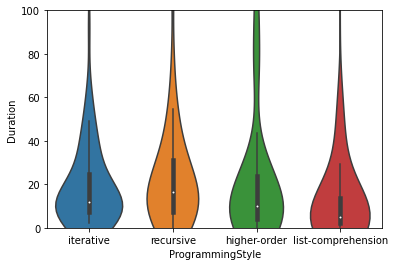

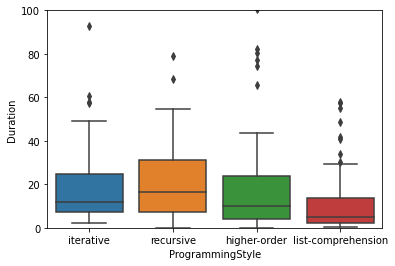

In [124]:
df_tmp = df_category.copy()
df_tmp["Duration"] = df_tmp["Duration"].astype(float)
ax = sns.violinplot(x="ProgrammingStyle", y="Duration", data=df_tmp)
ax.set(ylim=(0, 100))
plt.savefig("./results/visual_attention_aoi_time_in_style_duration_violin.png")
plt.show()
plt.close('all')

df_tmp = df_category.copy()
df_tmp["Duration"] = df_tmp["Duration"].astype(float)
ax = sns.boxplot(x="ProgrammingStyle", y="Duration", data=df_tmp)
ax.set(ylim=(0, 100))
plt.savefig("./results/visual_attention_aoi_time_in_style_duration_boxplot.png")
plt.show()
plt.close('all')

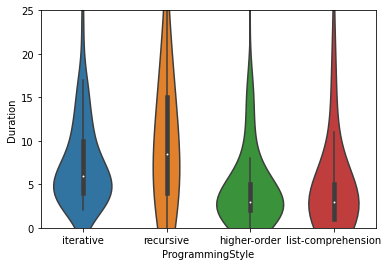

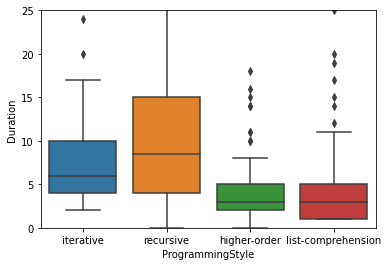

In [125]:
df_tmp = df_category.copy()
df_tmp["Duration"] = df_tmp["Number"].astype(float)
ax = sns.violinplot(x="ProgrammingStyle", y="Duration", data=df_tmp)
ax.set(ylim=(0, 25))
plt.savefig("./results/visual_attention_aoi_time_in_style_duration_violin.png")
plt.show()
plt.close('all')

df_tmp = df_category.copy()
df_tmp["Duration"] = df_tmp["Number"].astype(float)
ax = sns.boxplot(x="ProgrammingStyle", y="Duration", data=df_tmp)
ax.set(ylim=(0, 25))
plt.savefig("./results/visual_attention_aoi_time_in_style_duration_boxplot.png")
plt.show()
plt.close('all')

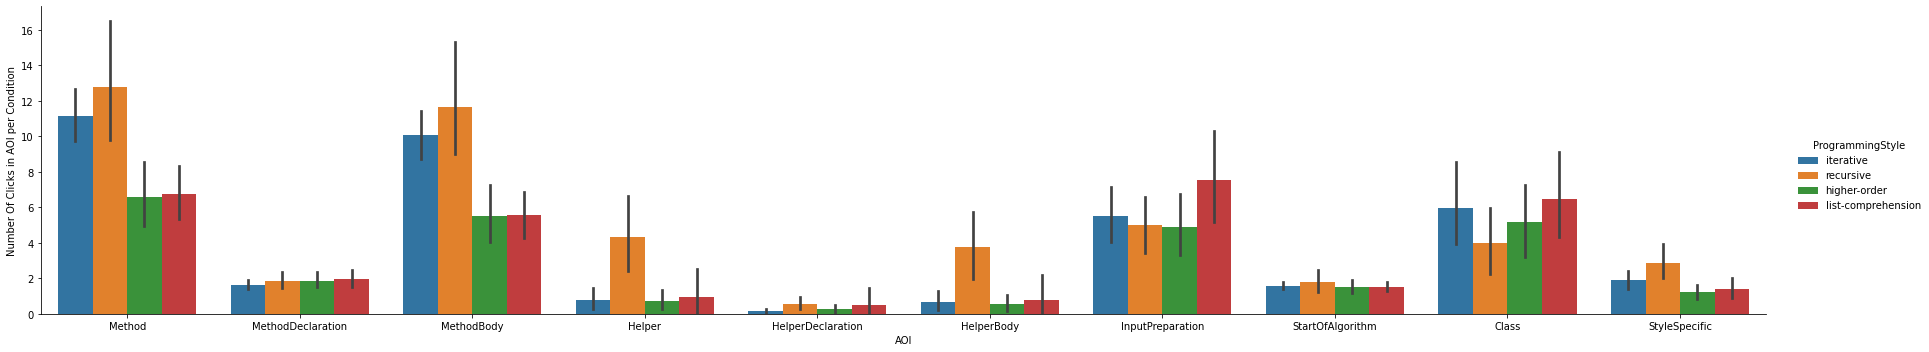

In [126]:
df_tmp = df_aoi.copy()
df_tmp.loc[df_tmp["AOI"]=="iteration", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="recursive", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="list-comprehension", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="higher-order", "AOI"] = "StyleSpecific"
ax = sns.catplot(x="AOI", y="Number", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5, aspect=5)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks in AOI per Condition')
plt.savefig("./results/visual_attention_aoi_number_of_clicks.png")
plt.show()
plt.close('all')

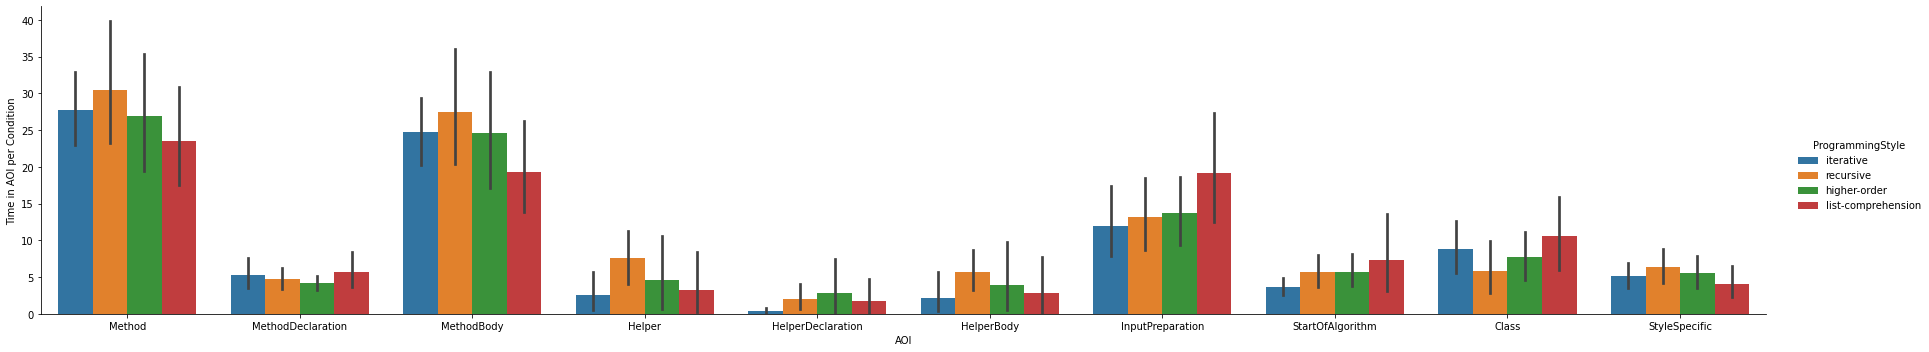

In [127]:
df_tmp = df_aoi.copy()
df_tmp.loc[df_tmp["AOI"]=="iteration", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="recursive", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="list-comprehension", "AOI"] = "StyleSpecific"
df_tmp.loc[df_tmp["AOI"]=="higher-order", "AOI"] = "StyleSpecific"
ax = sns.catplot(x="AOI", y="Duration", hue="ProgrammingStyle", data=df_tmp, kind="bar", height=5, aspect=5)
ax.tight_layout()
ax.set(ylabel='Time in AOI per Condition')
plt.savefig("./results/visual_attention_aoi_time.png")
plt.show()
plt.close('all')

  0%|          | 0/8 [00:00<?, ?it/s]

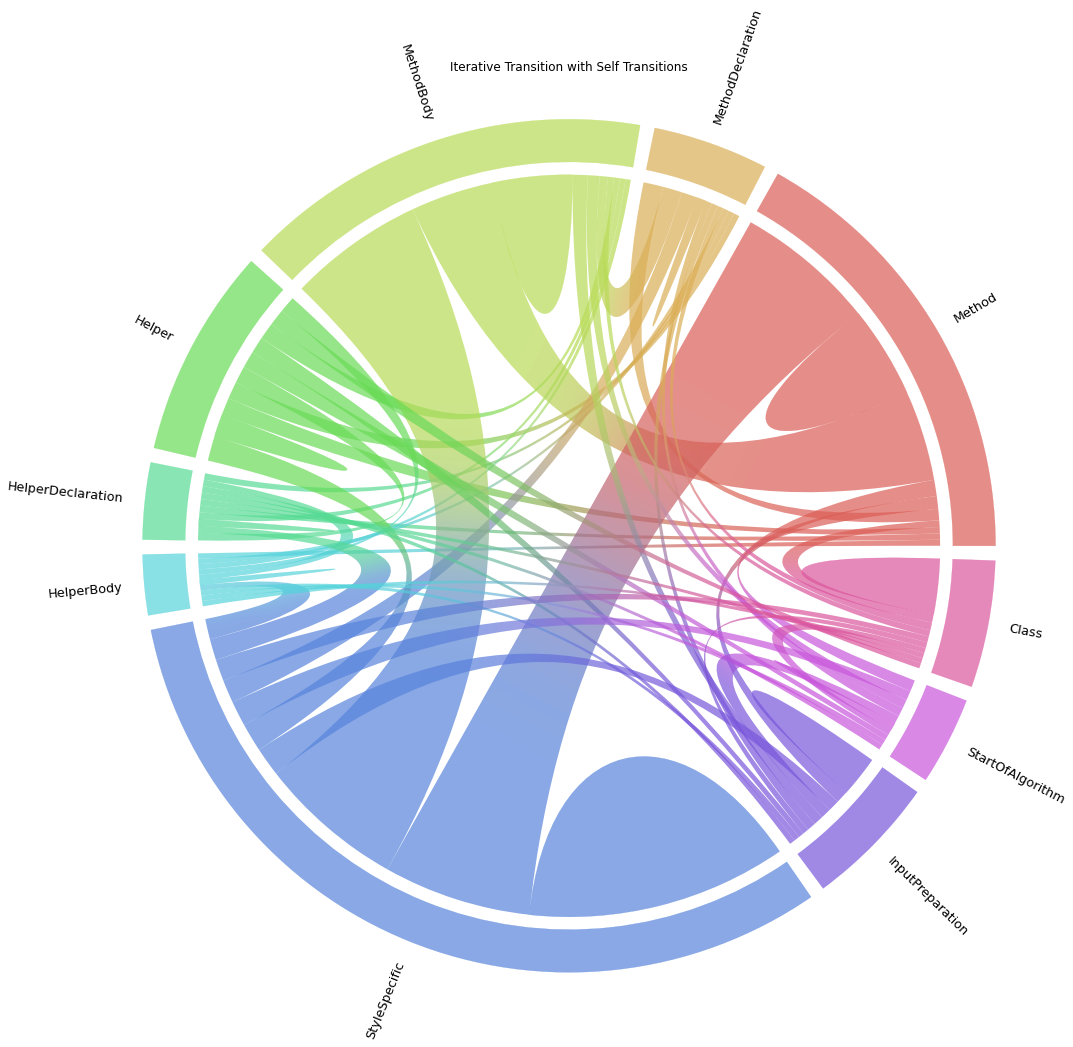

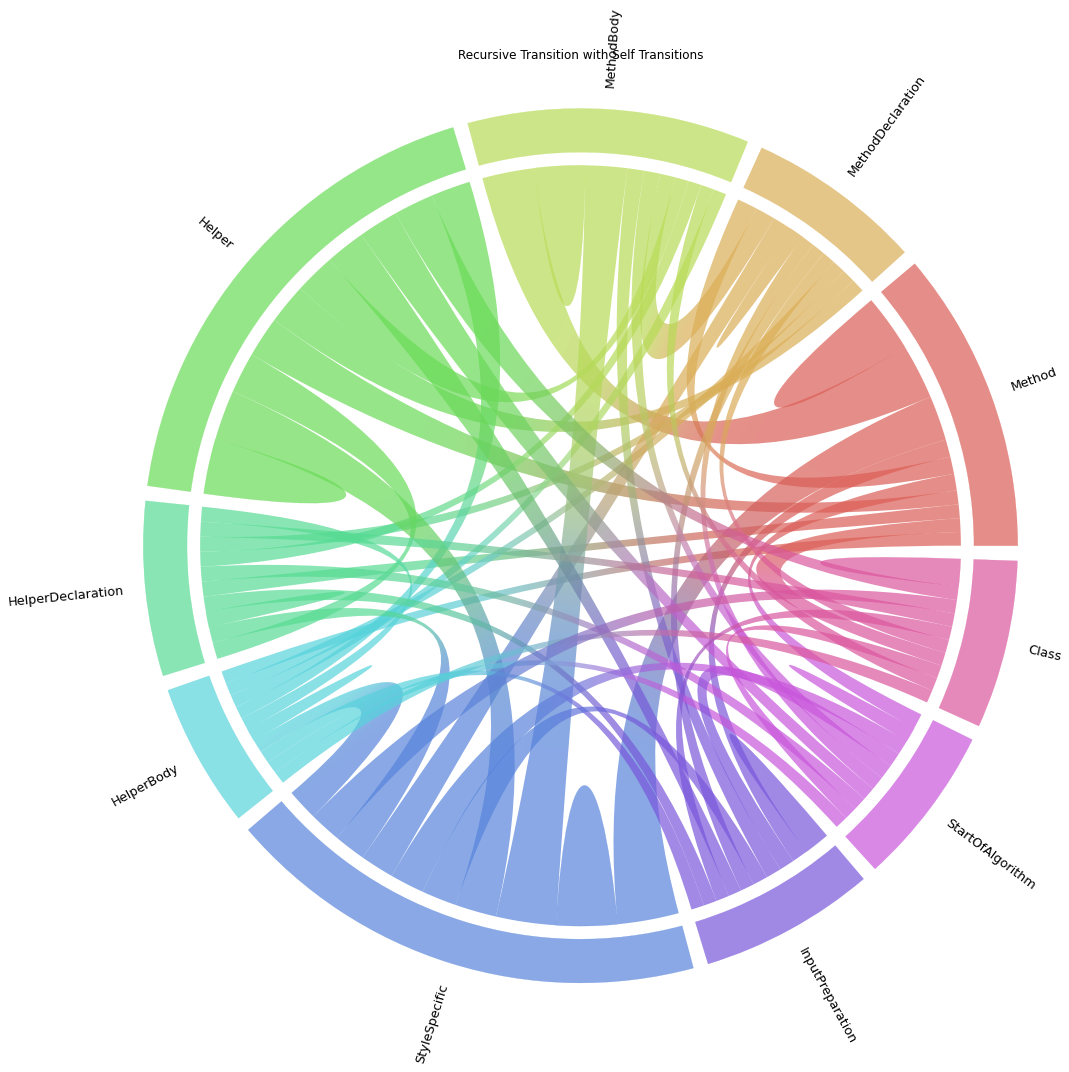

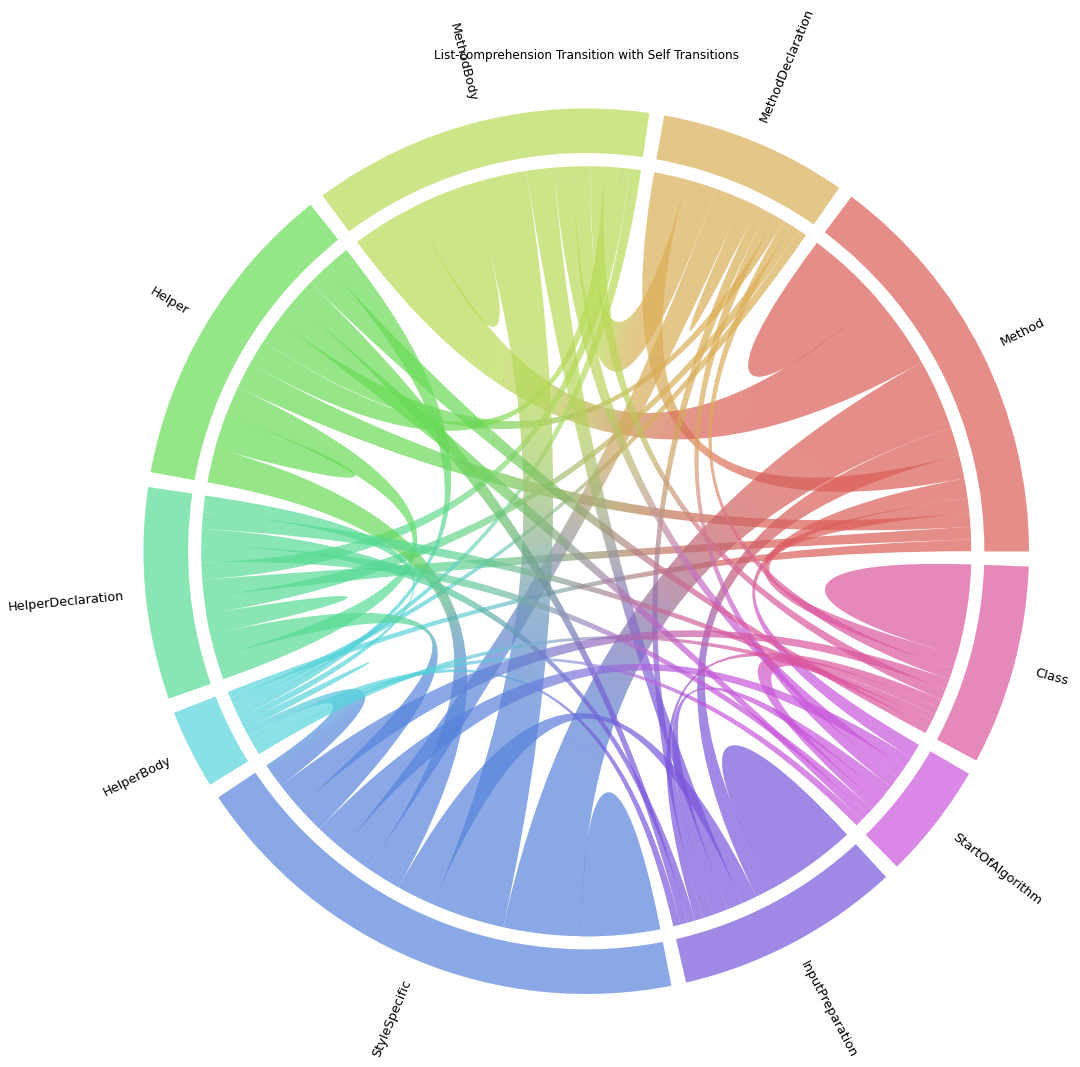

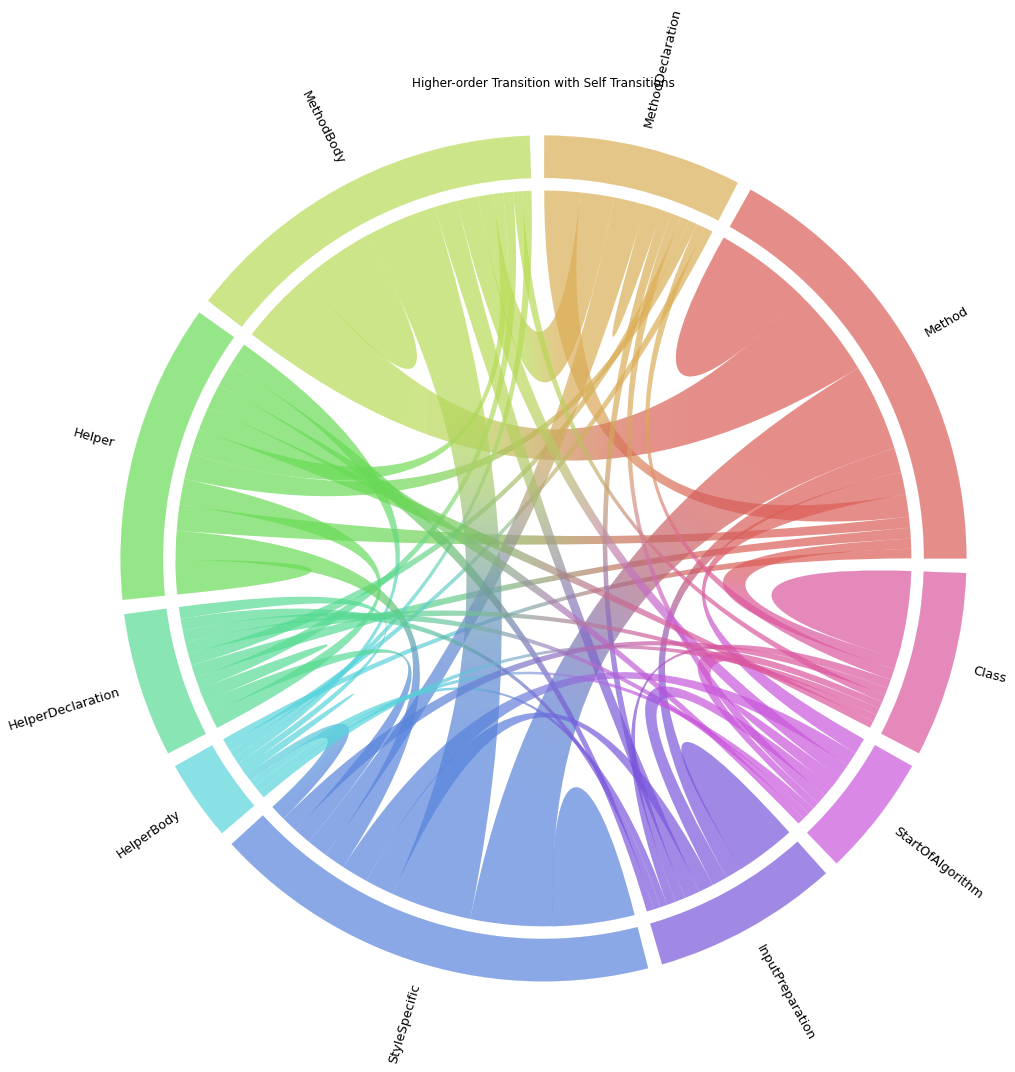

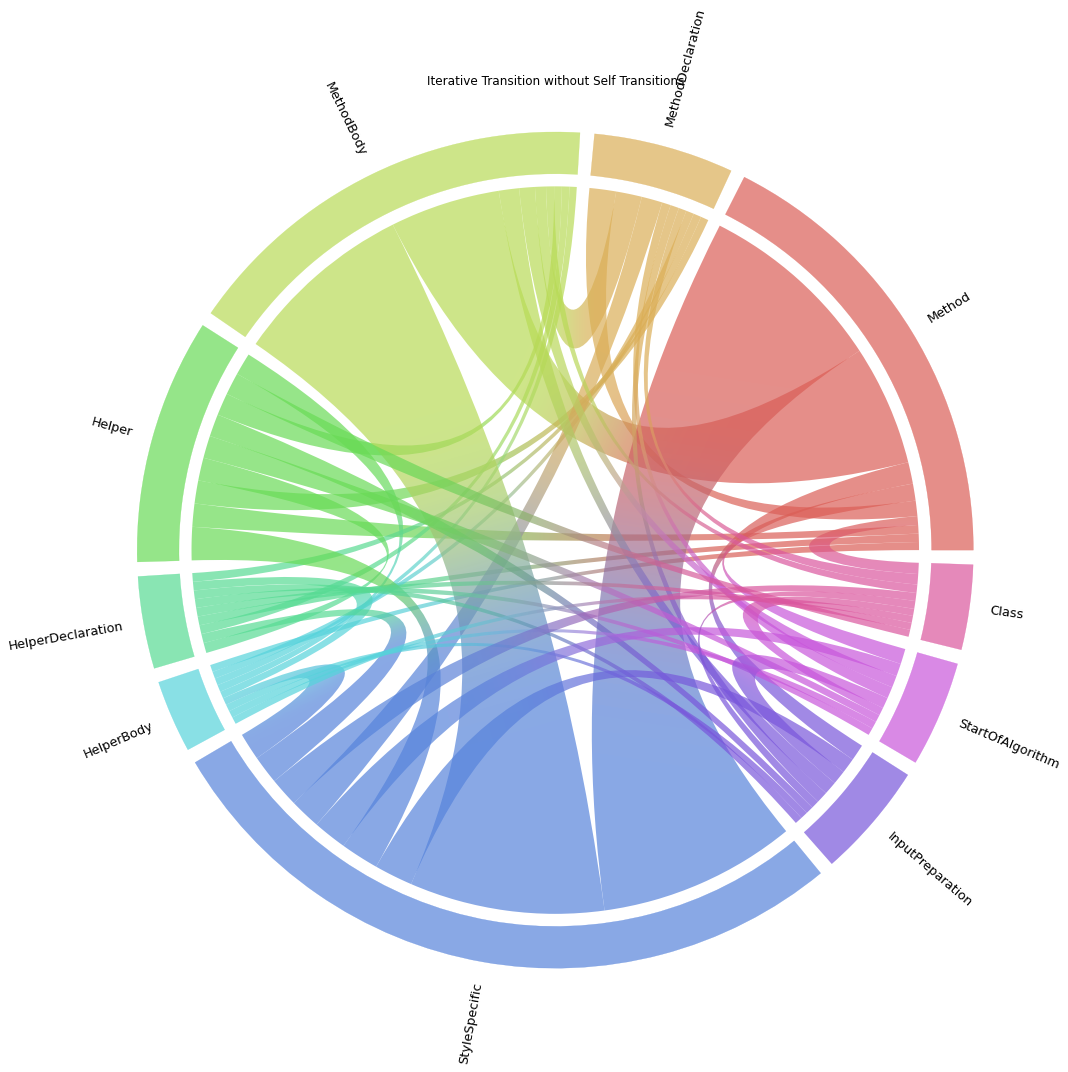

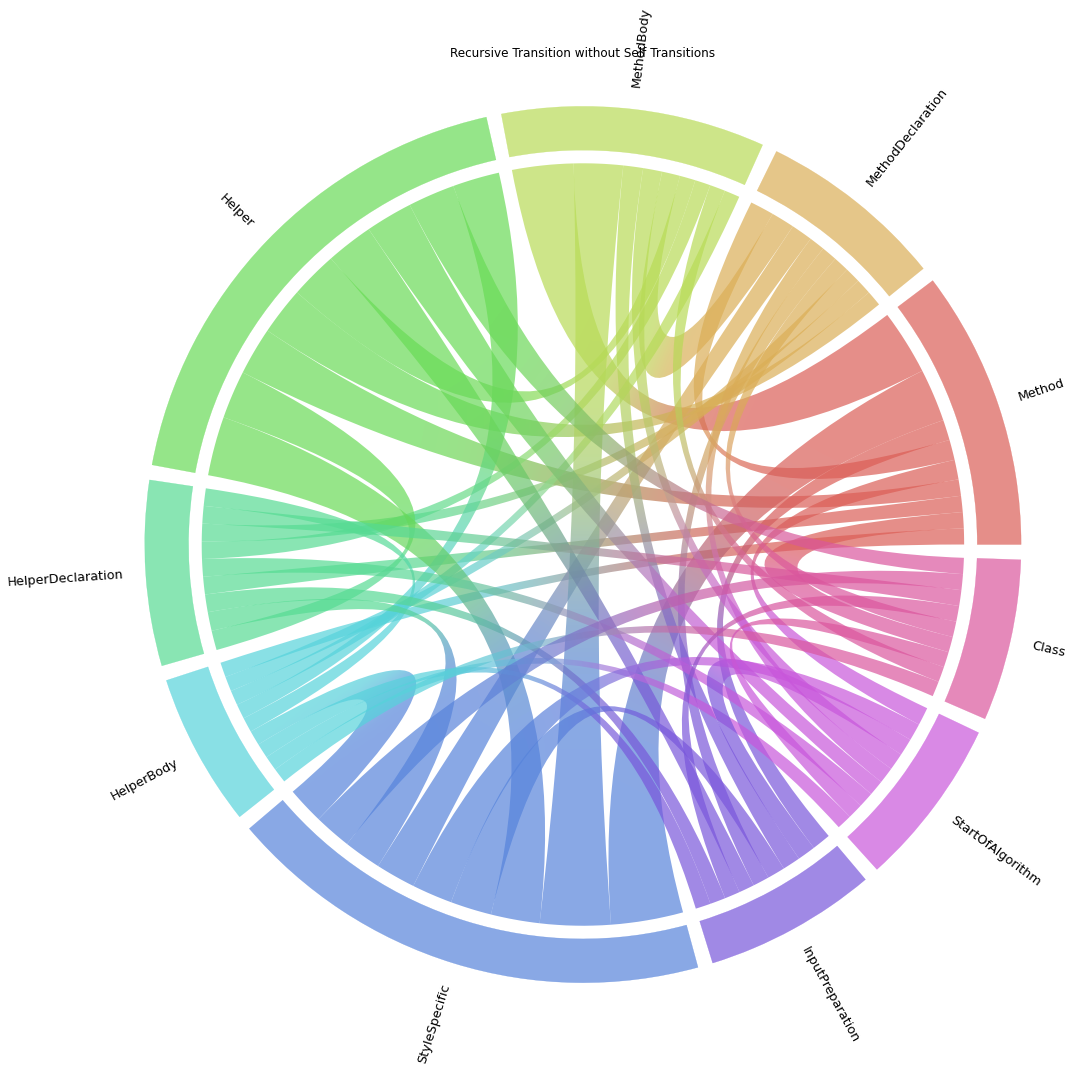

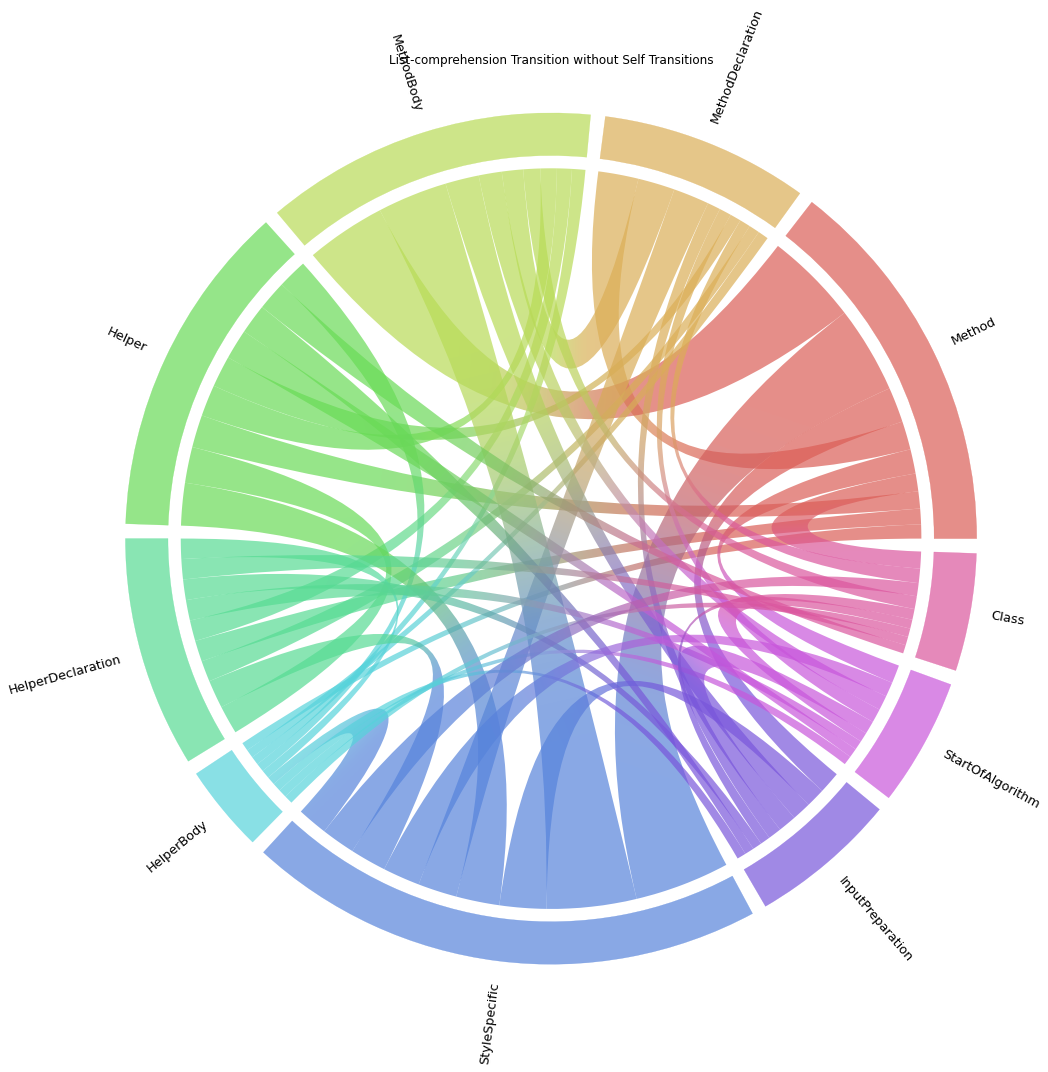

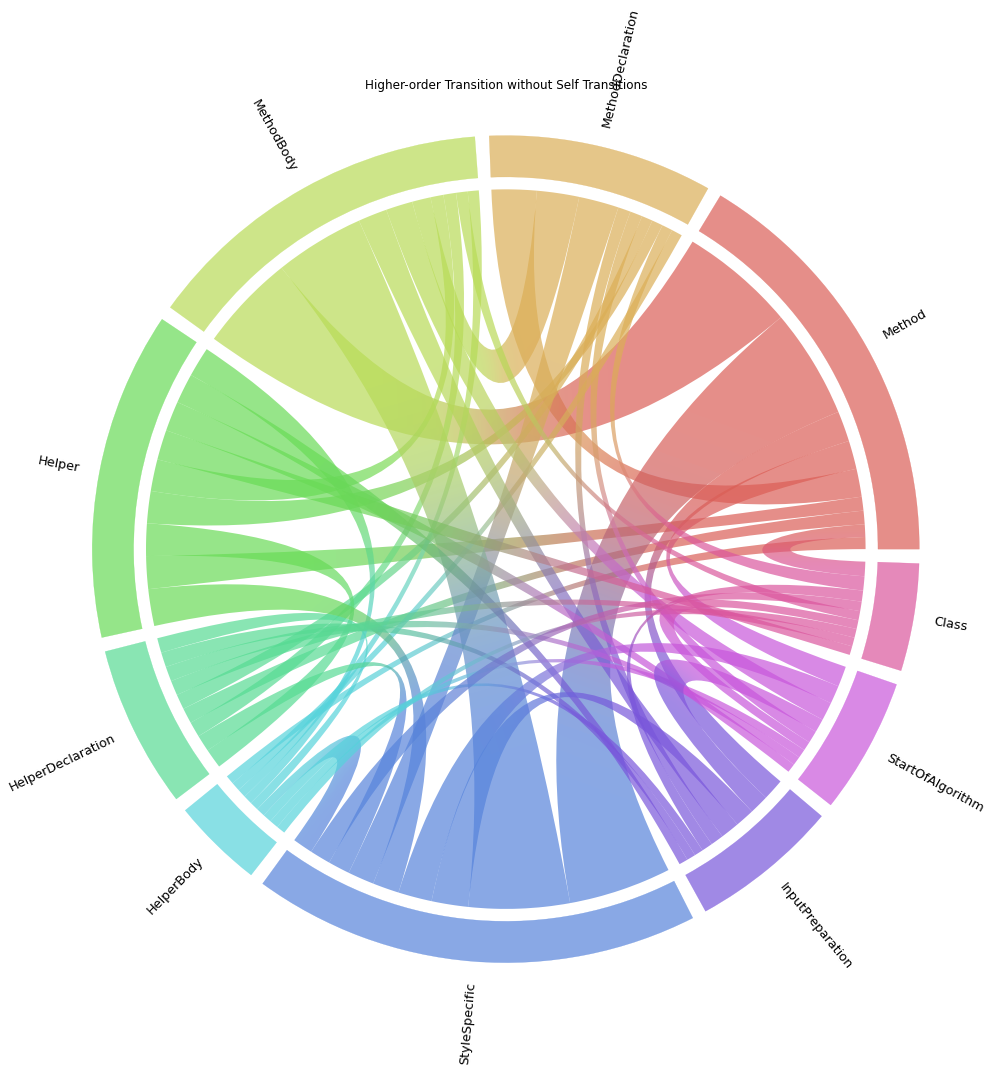

True

In [128]:
def chord(data, names, colors, title, path, diagonal_to_zero=False):
    data_tmp = data.copy()
    if diagonal_to_zero:
        np.fill_diagonal(data_tmp, 0)
    fig, ax = plt.subplots(figsize=(15, 15))
    chord_diagram(data_tmp, names=names, colors=colors, ax=ax, use_gradient=True, rotate_names=True)
    plt.tight_layout()
    plt.title(title)
    plt.savefig(path)
    plt.show()
    plt.close('all')

p_bar = tqdm(range(8))
chord(iterative_transition, aoi_names_convoluted, aoi_colors_convoluted, "Iterative Transition with Self Transitions", "./results/chord/transitions_self_iterative.png")
p_bar.update(0)
p_bar.refresh()
chord(recursive_transition, aoi_names_convoluted, aoi_colors_convoluted, "Recursive Transition with Self Transitions", "./results/chord/transitions_self_recursive.png")
p_bar.update(1)
p_bar.refresh()
chord(list_comprehension_transition, aoi_names_convoluted, aoi_colors_convoluted, "List-comprehension Transition with Self Transitions", "./results/chord/transitions_self_list_comprehension.png")
p_bar.update(2)
p_bar.refresh()
chord(higher_order_transition, aoi_names_convoluted, aoi_colors_convoluted, "Higher-order Transition with Self Transitions", "./results/chord/transitions_self_higher_order.png")
p_bar.update(3)
p_bar.refresh()

chord(iterative_transition, aoi_names_convoluted, aoi_colors_convoluted, "Iterative Transition without Self Transitions", "./results/chord/transitions_iterative.png", diagonal_to_zero=True)
p_bar.update(4)
p_bar.refresh()
chord(recursive_transition, aoi_names_convoluted, aoi_colors_convoluted, "Recursive Transition without Self Transitions", "./results/chord/transitions_recursive.png", diagonal_to_zero=True)
p_bar.update(5)
p_bar.refresh()
chord(list_comprehension_transition, aoi_names_convoluted, aoi_colors_convoluted, "List-comprehension Transition without Self Transitions", "./results/chord/transitions_list_comprehension.png", diagonal_to_zero=True)
p_bar.update(6)
p_bar.refresh()
chord(higher_order_transition, aoi_names_convoluted, aoi_colors_convoluted, "Higher-order Transition without Self Transitions", "./results/chord/transitions_higher_order.png", diagonal_to_zero=True)
p_bar.update(7)
p_bar.refresh()